In [1]:
%time
%load_ext autotime
%load_ext autoreload
%autoreload 2
# add path
import os 
import sys 
parent_dir = os.path.abspath(os.getcwd()+'/..')+'/' 
sys.path.append(parent_dir) 

# main
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

from utils.path import dir_HugeFiles
from utils.preprocessing import load
from utils.save import make_dir, save_pickle, load_pickle, auto_save_csv, print_time, auto_save_pickle

from scipy.stats import pearsonr, pointbiserialr

from pylab import rcParams
rcParams['figure.figsize'] = [4.5, 3.0]
from matplotlib import gridspec
from scipy import stats

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs


In [2]:
dir_save = os.path.normpath(dir_HugeFiles+'dph/dic_20190607.pickle')
dic = load(dir_save)

exist
time: 9.56 s


In [3]:
amt_GI = load_pickle('../data/amt_hGI_pos.pickle')
for i, v in dic.items():
    if i in amt_GI.keys():
        v['AMT'] = amt_GI[i]
amt_ls = list(amt_GI.keys())
ls = amt_ls
print('load the UD labels, there are %d UD recipes' % sum(amt_GI.values()))

load the UD labels, there are 506 UD recipes
time: 40.3 ms


### Derive the FSA color codes

In [4]:
for i, v in dic.items():
    if i in ls:
        if v['total fat']/v['servings']>10.5 and v['dry_weight']/v['servings'] >100:
            score = 3
        elif v['total fat/dry_weight']*100<=3:
            score = 1
        elif v['total fat/dry_weight']*100<=17.5:
            score = 2
        else:
            score = 3
        dic[i]['fsa_fat'] = score
        
        if v['saturated fat']/v['servings']>6 and v['dry_weight']/v['servings'] >100:
            score = 3
        elif v['saturated fat/dry_weight']*100<=1.5:
            score = 1
        elif v['saturated fat/dry_weight']*100<=5:
            score = 2
        else:
            score = 3
        dic[i]['fsa_saturated'] = score
        
        if v['sugars']/v['servings']>27 and v['dry_weight']/v['servings'] >100:
            score = 3
        elif v['sugars/dry_weight']*100<=5:
            score = 1
        elif v['sugars/dry_weight']*100<=22.5:
            score = 2
        else:
            score = 3
        dic[i]['fsa_sugar'] = score
        
        if v['sodium']/v['servings']/22.98*58.44>1.8 and v['sodium']/v['servings']/22.98*58.44 >100:
            score = 3
        elif v['sodium/dry_weight']/22.98*58.44*100/1000<=0.3:
            score = 1
        elif v['sodium/dry_weight']/22.98*58.44*100/1000<=1.5:
            score = 2
        else:
            score = 3
        dic[i]['fsa_salt'] = score
        dic[i]['fsa_sum'] = dic[i]['fsa_fat']+dic[i]['fsa_saturated']+dic[i]['fsa_sugar']+dic[i]['fsa_salt']

time: 867 ms


In [5]:
df = pd.DataFrame.from_dict(dic, orient = 'index')[['AMT','fsa_sum','fsa_fat','fsa_saturated','fsa_sugar','fsa_salt']]
df = df.dropna()
df['fsa_sum'] = df['fsa_sum'].astype(int)
df = df.rename({'fsa_sum': 'FSA Healthiness Score', 
                'fsa_fat': 'FSA Fat Color Code','fsa_saturated': 'FSA Saturates Color Code', 
                'fsa_sugar': 'FSA Sugars Color Code', 'fsa_salt': 'FSA Salt Color Code'}, axis = 'columns')

time: 6.3 s


In [6]:
cols = ['FSA Healthiness Score',
        'FSA Fat Color Code',
        'FSA Saturates Color Code',
        'FSA Sugars Color Code',
        'FSA Salt Color Code']
df['labels'] = ['2_HD' if i ==0 else '1_UD' for i in df.AMT ]
df_packed = []
for col in cols:
    df_temp = df[['labels',col]].rename({col:'score'},axis =1)
    df_temp['code'] = col
    df_packed.append(df_temp)
df_packed = pd.concat(df_packed, axis = 0, sort = False).reset_index(drop=True)

time: 49.8 ms


because we want UD be in the front of HD, so we place some number in front of the labels 

/home/helena/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'')

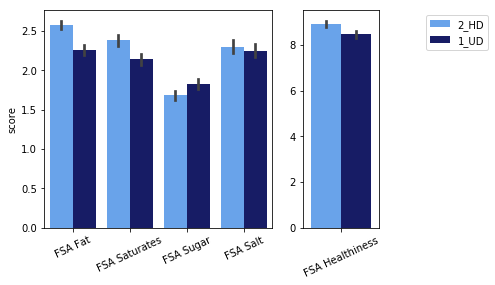

time: 824 ms


In [7]:
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
clrs = ['#54a1ff','#0a1172']
# First
plt.subplot(gs[0])
ax = sns.barplot(x='code', y='score', hue = 'labels', palette = clrs,
                 data = df_packed[df_packed['code']!= 'FSA Healthiness Score'])
ax.set_xticklabels(['FSA Fat','FSA Saturates',"FSA Sugar","FSA Salt"], 
                               fontsize=10, rotation=25)
ax.set_xlabel('')
ax.get_legend().remove()

# Second
plt.subplot(gs[1])
ax = sns.barplot(x='code', y='score', hue = 'labels', palette = clrs,
                 data = df_packed[df_packed['code']== 'FSA Healthiness Score'])
ax.set_xticklabels(['FSA Healthiness'], fontsize=10, rotation=25)

ax.legend(loc='upper right',bbox_to_anchor=(2.5,1))
ax.set_xlabel('')
ax.set_ylabel('')
#plt.savefig('../figs/fsa_bar.jpg', bbox_inches='tight')

In [8]:
# alltogether dunn and kw
from utils.kw_dunn import kw_dunn
from itertools import combinations
df_m = pd.melt(df, id_vars=['AMT'], value_vars=cols)
gb = df_m.groupby(['AMT','variable'])['value'].apply(list)
H, p_omnibus, Z_pairs, p_corrected, reject = kw_dunn(gb)
names = tuple(gb.index.tolist())
for pair, r, p in tuple(zip(list(combinations(names,2)),reject,p_corrected)):
    if r:
        print(pair,r,p)

((0.0, 'FSA Fat Color Code'), (0.0, 'FSA Healthiness Score')) True 2.909321579334651e-103
((0.0, 'FSA Fat Color Code'), (0.0, 'FSA Salt Color Code')) True 0.034387369607780875
((0.0, 'FSA Fat Color Code'), (0.0, 'FSA Sugars Color Code')) True 4.810685467994908e-37
((0.0, 'FSA Fat Color Code'), (1.0, 'FSA Fat Color Code')) True 4.909721522419432e-05
((0.0, 'FSA Fat Color Code'), (1.0, 'FSA Healthiness Score')) True 8.946601891572455e-97
((0.0, 'FSA Fat Color Code'), (1.0, 'FSA Salt Color Code')) True 0.0015329276344839432
((0.0, 'FSA Fat Color Code'), (1.0, 'FSA Saturates Color Code')) True 6.028679302581831e-09
((0.0, 'FSA Fat Color Code'), (1.0, 'FSA Sugars Color Code')) True 7.714223165591333e-26
((0.0, 'FSA Healthiness Score'), (0.0, 'FSA Salt Color Code')) True 1.4054565959250182e-137
((0.0, 'FSA Healthiness Score'), (0.0, 'FSA Saturates Color Code')) True 6.047982961753928e-131
((0.0, 'FSA Healthiness Score'), (0.0, 'FSA Sugars Color Code')) True 3.919830426328241e-263
((0.0, 'FSA

### correlation experiment

In [9]:
df_load = pd.read_csv('../data/labeled.csv')
def amt_EM(df,label_convert):
    df = df[['Input.id','WorkerId','Answer.Your answer.label']]
    df = df.assign(label= df['Answer.Your answer.label'].map(label_convert))
    df = df.dropna()
    df = df[['WorkerId','Input.id','label']].rename({'WorkerId':'Annotator','Input.id':'Question','Annotation':'label'}, axis = 1)
    return df

label_convert = dict(zip(['1 - Strongly Disagree','2','3','4',
                      '5 - Strongly Agree','Not Sure'], [1,2,3,4,5,np.nan]))
df_EM = amt_EM(df_load, label_convert)

df_EM['id'] = df_EM['Question'].apply(lambda x: int(''.join(filter(str.isdigit, x))))

time: 151 ms


In [10]:
average_rating = df_EM.groupby('id')[['label']].mean().loc[ls]

after_DS = pd.read_csv('../data/predict.csv').iloc[1:]
after_DS['id'] = after_DS['Question'].apply(lambda x: int(''.join(filter(str.isdigit,x))))
after_DS['GI'] = after_DS['Annotation'].apply(lambda x: int(''.join(filter(str.isdigit,x))))
after_DS = after_DS.set_index('id').loc[ls].sort_index()

correlation_tb = []
for col in cols:
    r, p =pearsonr(df[col], average_rating.label.values)
    row = col, round(r,3), round(p, 3)
    correlation_tb.append(row)
pd.DataFrame(correlation_tb, columns = ['score', 'correlation','p-value'])

,score,correlation,p-value
0,FSA Healthiness Score,0.033,0.299
1,FSA Fat Color Code,0.055,0.083
2,FSA Saturates Color Code,0.019,0.545
3,FSA Sugars Color Code,-0.020,0.528
4,FSA Salt Color Code,0.015,0.640


time: 1.83 s


In [11]:
correlation_tb = []
for col in cols:
    r, p =pointbiserialr(df['AMT'],df[col])
    row = col, round(r,3), round(p, 3)
    correlation_tb.append(row)
pd.DataFrame(correlation_tb, columns = ['score', 'correlation','p-value'])

,score,correlation,p-value
0,FSA Healthiness Score,-0.146,0.000
1,FSA Fat Color Code,-0.238,0.000
2,FSA Saturates Color Code,-0.156,0.000
3,FSA Sugars Color Code,0.110,0.001
4,FSA Salt Color Code,-0.027,0.392


time: 30 ms


In [12]:
correlation_tb = []
for col in cols:
    r, p =pearsonr(df[col], after_DS['GI'])
    row = col, round(r,3), p
    correlation_tb.append(row)
pd.DataFrame(correlation_tb, columns = ['score', 'correlation','p-value'])

,score,correlation,p-value
0,FSA Healthiness Score,0.189,2.050337e-09
1,FSA Fat Color Code,0.299,6.893988e-22
2,FSA Saturates Color Code,0.190,1.525909e-09
3,FSA Sugars Color Code,-0.280,2.804761e-19
4,FSA Salt Color Code,0.148,3.073661e-06


time: 31.5 ms


### check nutriton distribution

In [13]:
nu_table = pd.DataFrame.from_dict(dic, orient = 'index')
dw = [col for col in nu_table.columns if 'dry_weight' in col]
dw.remove('dry_weight')
nu_table = nu_table[dw+['AMT']]
nu_table = nu_table.dropna()
nu_table = nu_table.rename(dict(zip(dw, [col[:-11] for col in dw])), axis = 1)
nu_table['labels'] = ['HD' if i ==0 else 'UD' for i in nu_table.AMT ]

time: 5 s


/home/helena/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


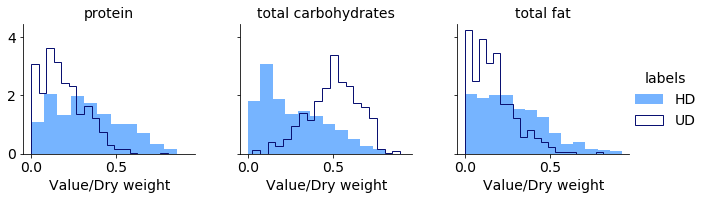

time: 580 ms


In [14]:
plt.rcParams.update({'font.size': 14})
clrs = ['#54a1ff','#0a1172']
mnu_table = pd.melt(nu_table, id_vars=['labels'], 
                    value_vars = ['protein', 'total carbohydrates','total fat'])
mnu_table = mnu_table.rename({'variable':'nutrition','value':'Value/Dry weight'}, axis=1)
d = {'hist_kws':[{'alpha':0.8},{'histtype':'step', 'alpha':1}]}
g = sns.FacetGrid(mnu_table, col = 'nutrition', hue = 'labels', 
                  palette = clrs, col_wrap = 3,
                 hue_kws = d)
g = (g.map(sns.distplot, 'Value/Dry weight', kde = False, norm_hist = True).add_legend().set_titles("{col_name}"))

#plt.savefig('../figs/nu_part1.jpg', bbox_inches='tight')

/home/helena/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


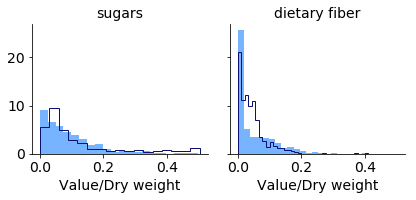

time: 358 ms


In [15]:
mnu_table = pd.melt(nu_table, id_vars=['labels'], 
                    value_vars = ['sugars','dietary fiber'])
mnu_table = mnu_table.rename({'variable':'nutrition','value':'Value/Dry weight'}, axis=1)
g = sns.FacetGrid(mnu_table, col = 'nutrition', hue = 'labels', 
                  palette = clrs, hue_kws = d)
g = (g.map(sns.distplot, 'Value/Dry weight', kde = False, norm_hist = True).set_titles("{col_name}"))
#plt.savefig('../figs/nu_part2.jpg', bbox_inches='tight')

/home/helena/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


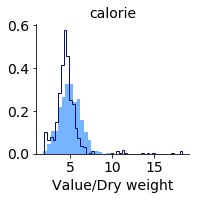

time: 234 ms


In [16]:
mnu_table = pd.melt(nu_table, id_vars=['labels'], 
                    value_vars = ['calorie'])
mnu_table = mnu_table.rename({'variable':'nutrition','value':'Value/Dry weight'}, axis=1)
g = sns.FacetGrid(mnu_table, col = 'nutrition', hue = 'labels', 
                  palette = clrs, hue_kws = d)
g = (g.map(sns.distplot, 'Value/Dry weight', kde = False, norm_hist = True).set_titles("{col_name}"))
#plt.savefig('../figs/nu_part3.jpg', bbox_inches='tight')

In [17]:
six = ['total carbohydrates','protein','total fat','sugars','dietary fiber','calorie']
for col in six:
    print(col)
    groups = nu_table.groupby('AMT').agg(col).apply(lambda x: list(x))
    ts = stats.ttest_ind(groups[0], groups[1])
    print(ts)

total carbohydrates
Ttest_indResult(statistic=-21.49515789510792, pvalue=2.186851321858751e-84)
protein
Ttest_indResult(statistic=13.504570179250019, pvalue=2.906974846562797e-38)
total fat
Ttest_indResult(statistic=11.0990097026159, pvalue=4.671890780289935e-27)
sugars
Ttest_indResult(statistic=-5.226809362994697, pvalue=2.1040911000809988e-07)
dietary fiber
Ttest_indResult(statistic=1.2657940098094944, pvalue=0.2058852373857447)
calorie
Ttest_indResult(statistic=3.723771840924853, pvalue=0.00020736832423525807)
time: 38.3 ms
